# Проверка гипотез по увеличению выручки в интернет-магазине 

**Цель работы**:  Приоритизировать гипотезы для увеличения выручки крупного интернет-магазина, запустить A/B-тест и проанализировать полученные результаты.

**Основные задачи**:

1. Применить фреймворки ICE и RICE для приоритизации гипотез; 


2. Проанализировать A/B-тест:
- построить график кумулятивной выручки по группам;
- построить график кумулятивного среднего чека по группам;
- построить график относительного изменения кумулятивного среднего чека группы B к группе A;
- построить график кумулятивного среднего количества заказов на посетителя по группам;
- построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
- построить точечный график количества заказов по пользователям;
- выбрать границу для определения аномальных пользователей;
- построить точечный график стоимостей заказов;
- выбрать границу для определения аномальных заказов;
- посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным;
- посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным;
- посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
- посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным;
- принять решение по результатам теста.


Данные 9 гипотез по увеличению выручки интернет-магазина хранятся в файле **/datasets/hypothesis.csv**, где: 
- **Hypothesis** — краткое описание гипотезы;
- **Reach** — охват пользователей по 10-балльной шкале;
- **Impact** — влияние на пользователей по 10-балльной шкале;
- **Confidence** — уверенность в гипотезе по 10-балльной шкале;
- **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Результаты A/B-тест описаны в файлах **/datasets/orders.csv** и **/datasets/visitors.csv**.

Файл **/datasets/orders.csv**:

- **transactionId** — идентификатор заказа;
- **visitorId** — идентификатор пользователя, совершившего заказ;
- **date** — дата, когда был совершён заказ;
- **revenue** — выручка заказа;
- **group** — группа A/B-теста, в которую попал заказ.

Файл **/datasets/visitors.csv**:

- **date** — дата;
- **group** — группа A/B-теста;
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных и подготовка их к анализу

### Загрузим данные из файлов в датафрейм

In [1]:
# Импортируем все необходимые библиотеки:
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# Вводим конфигурацию,улучшающую четкость картинок во всем проекте:
%config InlineBackend.figure_format = 'retina'

Загрузим данные о гипотезах, заказах и посетитиелях из CSV-файлов в переменные.

In [2]:
# Считываем данные из csv-файлов в датафреймы:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv') 
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# Выводим на экран полученные таблицы методом display(), но перед этим добавим код, чтобы текст в ячейке отражался полностью вне 
# зависимости от длины:
pd.set_option('display.max_colwidth', None)
display(hypothesis)
display(orders)
display(visitors)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [4]:
# Выводим основную информацию о каждом датафрейме с помощью метода info():
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Тип данных столбцов date, содержащих дату и время необходимо будет перевести из типа данных object в datetime.

### Проверим, есть ли про пропуски в данных

In [7]:
# Ищем пропуски в датафреймах методом isna() и sum(): 
hypothesis.isna().sum().sort_values(ascending=False)

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [8]:
orders.isna().sum().sort_values(ascending=False)

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [9]:
visitors.isna().sum().sort_values(ascending=False)

date        0
group       0
visitors    0
dtype: int64

Пропуски в анализируемых данных отсутствуют.

### Проверим наличие явных дубликатов в датафреймах

In [10]:
# Проверяем датафреймы на наличие явных дубликатов методом duplicated() и считаем их количество методом sum():
hypothesis.duplicated().sum()

0

In [11]:
orders.duplicated().sum()

0

In [12]:
visitors.duplicated().sum()

0

В данных нет явных дубликатов.

### Приведем заголовки столбцов датафреймов к нижнему и «змеиному» регистрам

In [13]:
# Приведем названия столбцов к нижнему регистру:
hypothesis.columns = hypothesis.columns.str.lower()
# Проверим, что получилось:
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [14]:
# Приведем названия столбцов в датафрейме orders к «змеиному» регистру:
orders.columns = orders.columns.str.replace('Id', '_id')
# Проверим, что получилось:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


### Изменим типы данных

In [15]:
# Преобразуем данные о дате:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

### Проверим, сколько групп в А/В тесте и нет ли в данных пользователей, попавших в обе группы А/В теста одновременно 

In [16]:
# Проверим, сколько групп в А/В тесте, а также сколько пользователей в каждой из этих групп: 
orders.groupby('group').agg({'visitor_id': 'nunique'})

,visitor_id
group,
A,503
B,586


В данном А/В тесте пользователей поделили на 2 группы, т.е. он парный, причем пользователей в группе В больше, чем в группе А на 16,5 %. В связи с этим, далее проверим, не попала ли часть пользователей в обе группы одновременно.

In [17]:
# Посчитаем сколько всего уникальных пользователей участвует в А/В тесте:
orders['visitor_id'].nunique()

1031

In [18]:
# Найдем количество уникальных пользователей, которые встречаются в двух группах одноверменно
orders.groupby('visitor_id').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

Таким образом, количество количество пользователей, попавших в обе группы одновременно, составляет чуть больше 5 % от общего числа пользователей, поэтому удалять их не будем, тем более из таблицы visitors их удалить не получится в любом случае.  

*Выводы по разделу 1:*

- В анализируемых данных пропуски и явные дубликаты не обнаружены; 
- Проведена следующая подготовка данных: типы данных во всех колонках соответствуют записанным в них значениям, названия колонок таблицы с гипотезами hypothesis приведены к нижнему регистру, а таблицы с заказами - к нижнему и «змеиному» регистрам.
- В А/В тесте 2 группы. Процент пользователей, попавших в обе группы А/В теста чуть более 5 %. Их решено было не удалять. 

## Приоритизация гипотез по увеличению выручки интернет-магазина 

### Применим фреймворк ICE для приоритизации гипотез

In [19]:
# Рассчитаем  ICE и добавим в датафрейм hypothesis новый столбец ice:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis['ice'] = round(hypothesis['ice'])

In [20]:
# Отсортируем гипотезы по убыванию приоритета:
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0


*Топ 4 наиболее перспективных гипотез по* **ICE**: 
- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

*Самая неперспективная гипотеза*:
- Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей

### Применим фреймворк RICE для приоритизации гипотез

In [21]:
# Рассчитаем  RICE и добавим в датафрейм hypothesis новый столбец rice:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [22]:
# Отсортируем гипотезы по убыванию приоритета:
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


*Топ 4 наиболее перспективных гипотез по* **RICE**: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

*Самая неперспективная гипотеза*:
- Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей

Выводы по разделу 2:

- В топ 4 наиболее популярных гипотез, приоритезированных по фраймворку  **RICE**, входят  3 гипотезы, приоритезированные по фраймворку **ICE**, однако у них другая последовательность. Вполне вероятно, что разный порядок приоритизации связан с тем, что фраймворк **RICE** учитывает, скольких пользователей затронет изменение, которое мы хотим внести, а **ICE** нет;
- Самая перспективная гипотеза по **ICE**: *Запустить акцию, дающую скидку на товар в день рождения*, а по **RICE**: *Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email*-рассылок. Самая непопулярная гипотеза и по **ICE** и по **RICE** одна и та же: *Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей*.     

## Анализ A/B-теста

### Построим график кумулятивной выручки по группам

Объединим таблицы **orders** и **visitors** в одну с понятными названиями столбцов. 

In [23]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Посмотрим на полученную таблицу:
print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

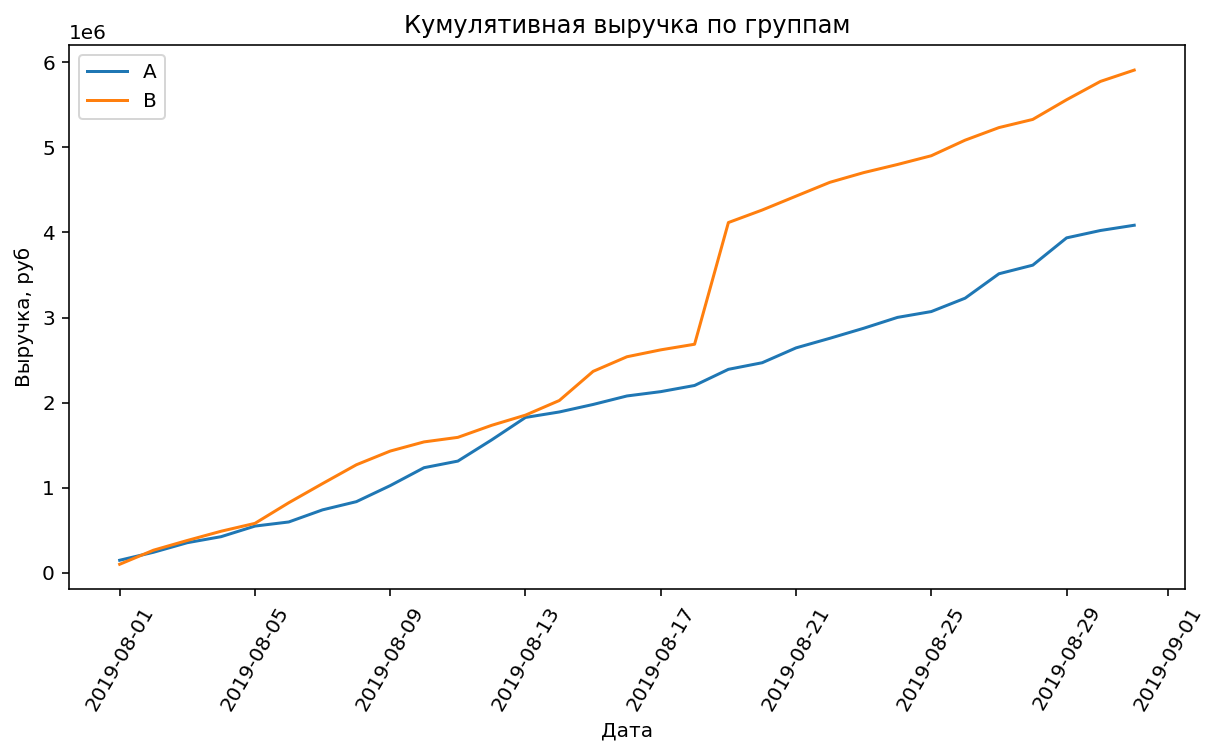

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=60)

plt.title('Кумулятивная выручка по группам')
plt.legend()
plt.ylabel('Выручка, руб')
plt.xlabel('Дата');

Выручка обеих групп увеличивается в течение всего теста: в группе А почти равномерно в течение всего теста, а в группе В наблюдается резкий рост с 18 по 19 августа, что может быть связано с резким ростом числа заказов, либо с появлением очень дорогих заказов в выборке.

### Построим график кумулятивного среднего чека по группам

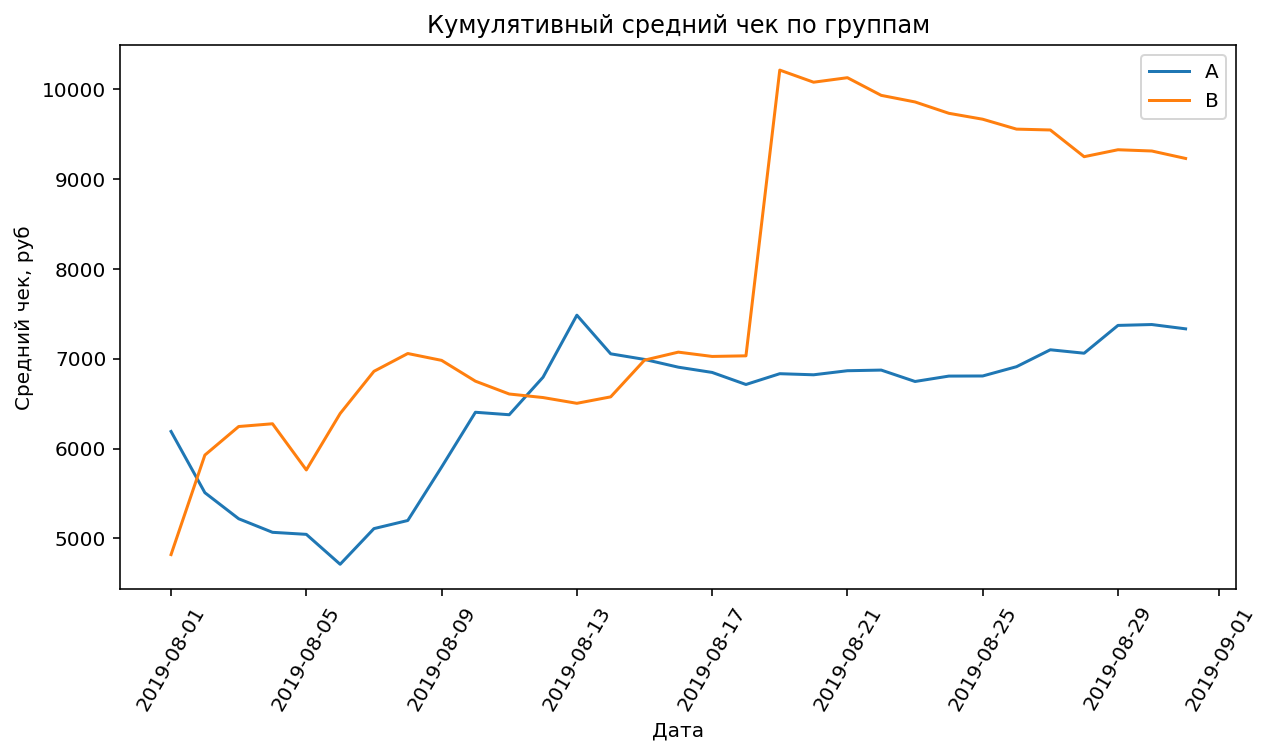

In [25]:
# Разделим кумулятивную выручку на кумулятивное число заказов и построим график:
plt.figure(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=60)
plt.ylabel('Средний чек, руб')
plt.xlabel('Дата')
plt.title('Кумулятивный средний чек по группам')
plt.legend();


Средний чек в группе А становится равномерным, начиная с середины теста, в группе В тенденция к выравниванию с середины теста прерывается резким ростом среднего чека (практически в 1,5 раза) и последующим его плавным уменьшением к концу теста. Такой резкий всплеск на графике может объясняться тем, что в выборку попали крупные заказы. Возможно, в группу B в первой половине теста попали крупные заказы (резкий всплеск на графике). В связи с этим группе В нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

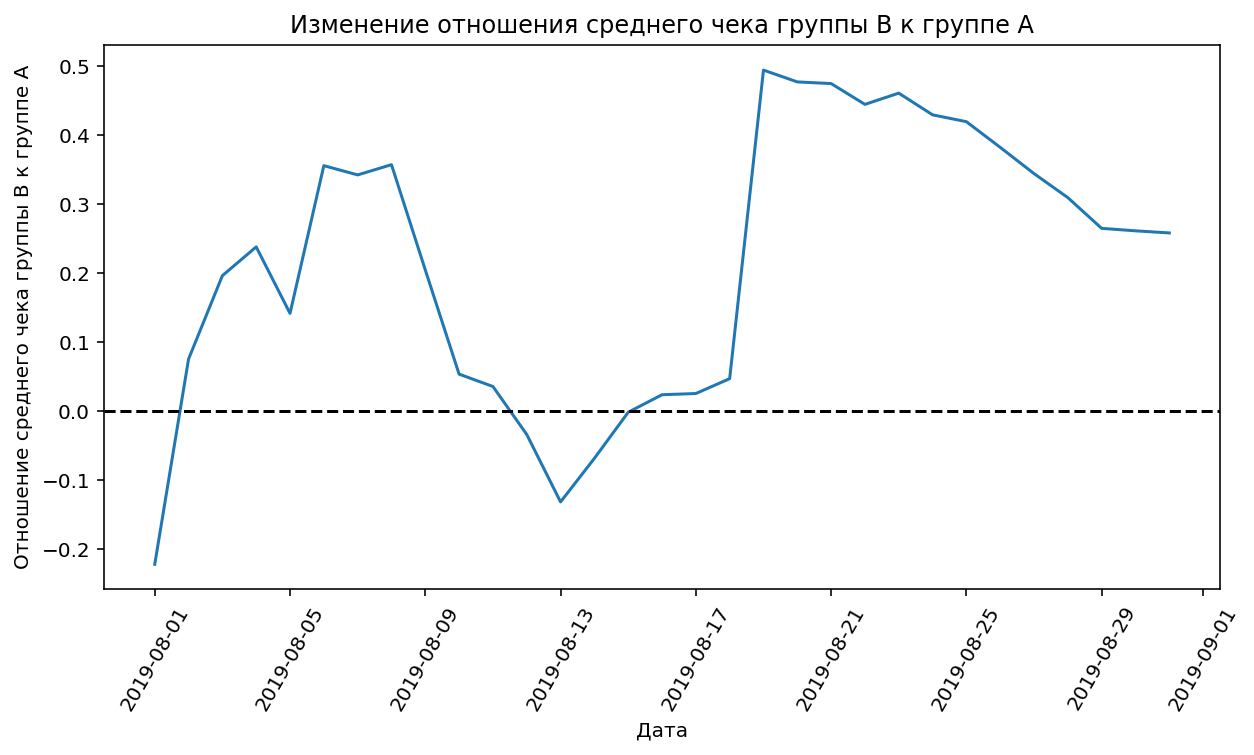

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10, 5))
# cтроим отношение средних чеков

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X методом axhline():
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=60)
plt.ylabel('Отношение среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.title('Изменение отношения среднего чека группы В к группе А');


В период с 8 по 17 августа график различия между сегментами резко падает и тут же растет, что подтверждает предположение о присутствии в выборке крупных заказов и выбросов, которые попробуем обнаружить позже. Вне этого диапазона средний чек пользователей из группы В выше, чем из группы А.

### Построим график кумулятивного среднего количества заказов на посетителя по группам

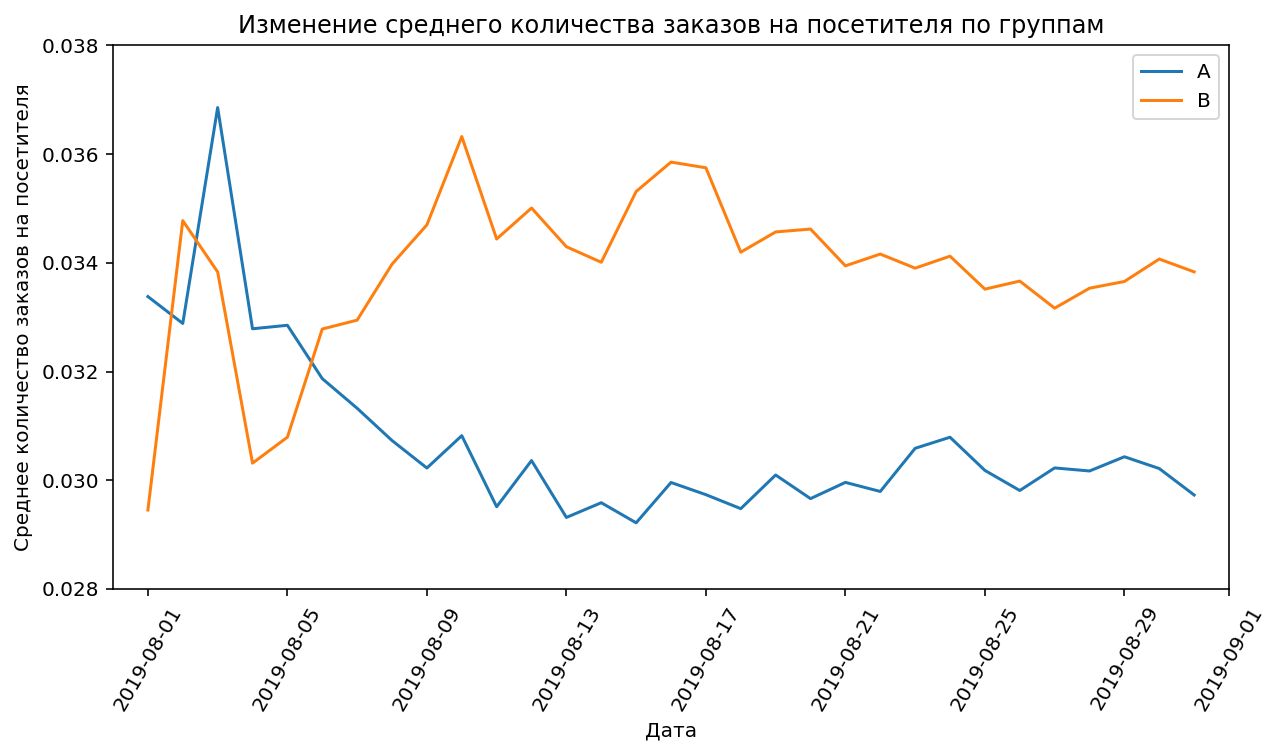

In [27]:
# считаем кумулятивное среднее количество заказов на посетителя по группам
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.xticks(rotation=60)
plt.ylabel('Среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.title('Изменение среднего количества заказов на посетителя по группам');
plt.legend()
# задаем масштаб осей
plt.axis([dt.datetime(2019,7,31), dt.datetime(2019,9,1), 0.028, 0.038]); 

На 4-й день теста среднее количество заказов на посетителя группы А и В сравнялось, после чего среднее количество заказов на посетителя группы В вырвалось вперед, а группы А снизилось, а далее значения обеих группах зафиксировались на определенном уровне. Среднее количество заказов на пользователя в группе В практически зафиксировалось на уровне на 16 % больше среднего количества заказов на пользователя в группе А.  

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

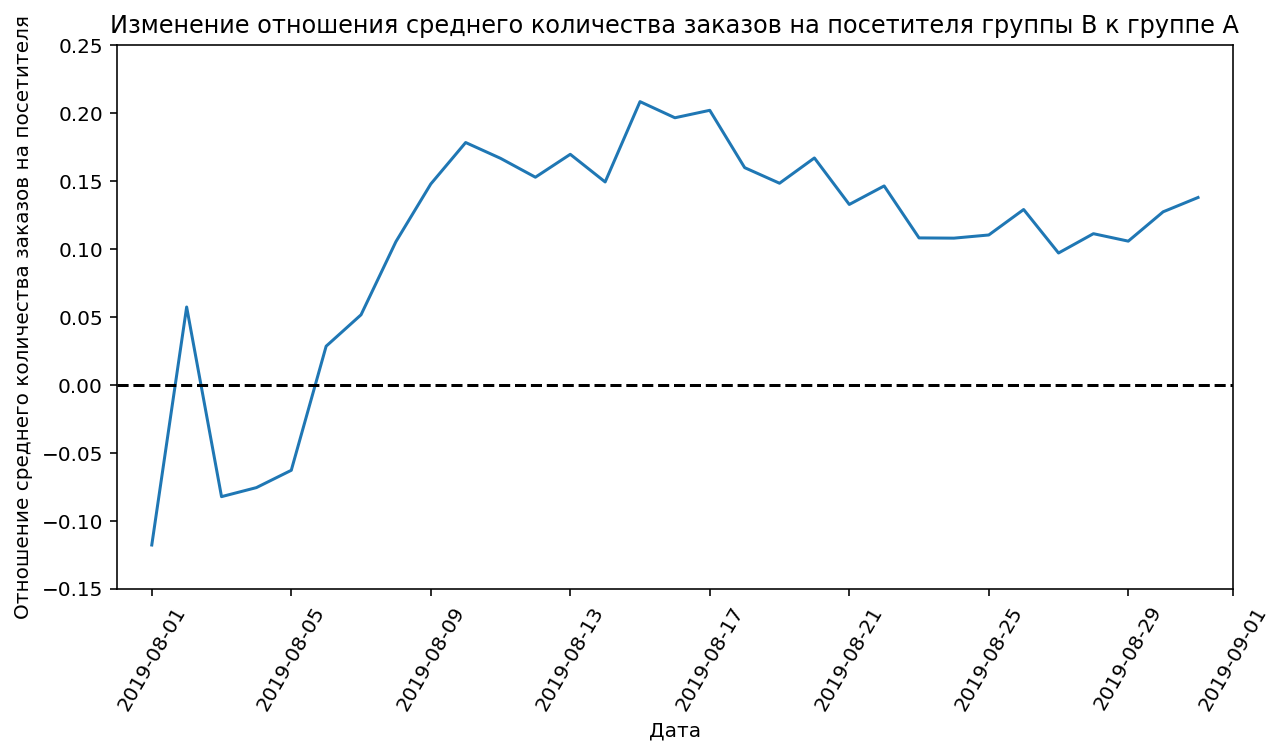

In [28]:
# Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:

mergedCumulativeConversions = (cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left', 
                                                                           suffixes=['A', 'B']))

plt.figure(figsize=(10, 5))
(
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1)
)
plt.xticks(rotation=60)
plt.axhline(y=0, color='black', linestyle='--')
#plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019,7,31), dt.datetime(2019,9,1), -0.15, 0.25])
plt.ylabel('Отношение среднего количества заказов на посетителя')
plt.xlabel('Дата')
plt.title('Изменение отношения среднего количества заказов на посетителя группы B к группе A');

Начиная с 5 дня теста группа B значительно вырвалась вперед и не пригрывала группе А вплоть до конца теста. В целом, кажется, что отношение среднего количества заказов ещё не установилось, но близко к этому. Но делать какие-либо однозначные выводы до анализа аномалий и последующего теста не стоит. 

### Построим точечный график количества заказов по пользователям

In [29]:
# Подсчитаем количество заказов по пользователям и посмотрим на результат:

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


В данных есть пользователи, которые совершали 5, 8, и 11 заказов, т.е. значительно больше, чем обычный пользователь.

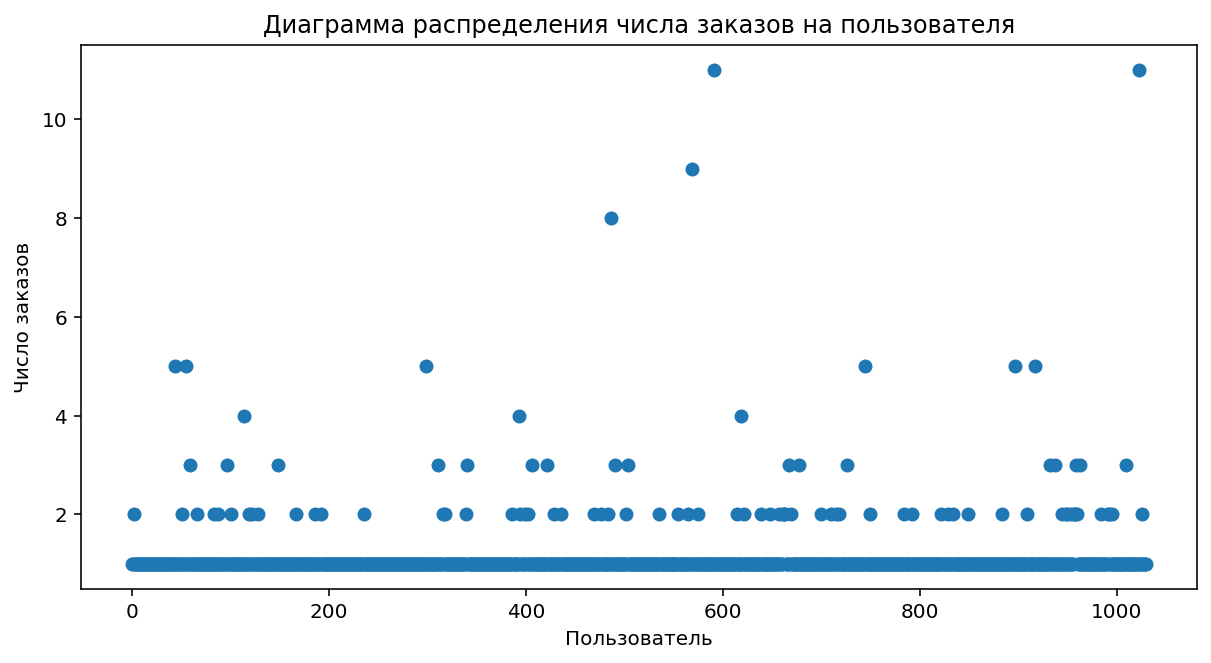

In [30]:
# Построим точечную диаграмму числа заказов на одного пользователя:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Число заказов')
plt.xlabel('Пользователь')
plt.title('Диаграмма распределения числа заказов на пользователя'); 

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2 и 3 заказами тоже значительна. Для более точного определения границы аномальных пользователей далее посчитаем перцентили.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [31]:
# Поcчитаем перцентили:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5 % пользователей оформляли больше 2 заказов, не более 1 % больше 4-х. 

За верхнюю границу числа заказов выберем 2 заказа, и далее будем удалять аномальных пользователей по ней.

### Построим точечный график стоимостей заказов

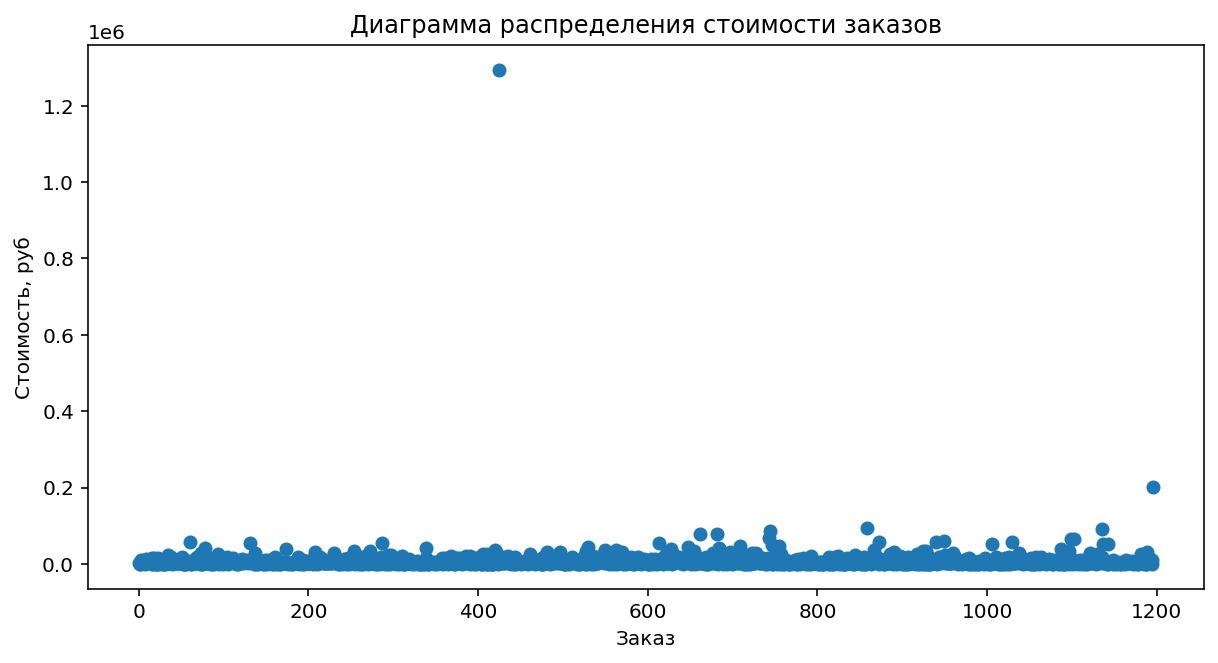

In [32]:
# Оценим стоимость заказов, построив точечную диаграмму:
plt.figure(figsize=(10, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Заказ')
plt.ylabel('Стоимость, руб')
plt.title('Диаграмма распределения стоимости заказов'); 

На диаграмме видно, что сильно выбиваются два значения: заказ более 1,2 млн рублей и заказ около 200 000 руб. Для того, чтобы посмотреть, как распределены остальные заказы, изменим масштаб диаграммы по оси оу.

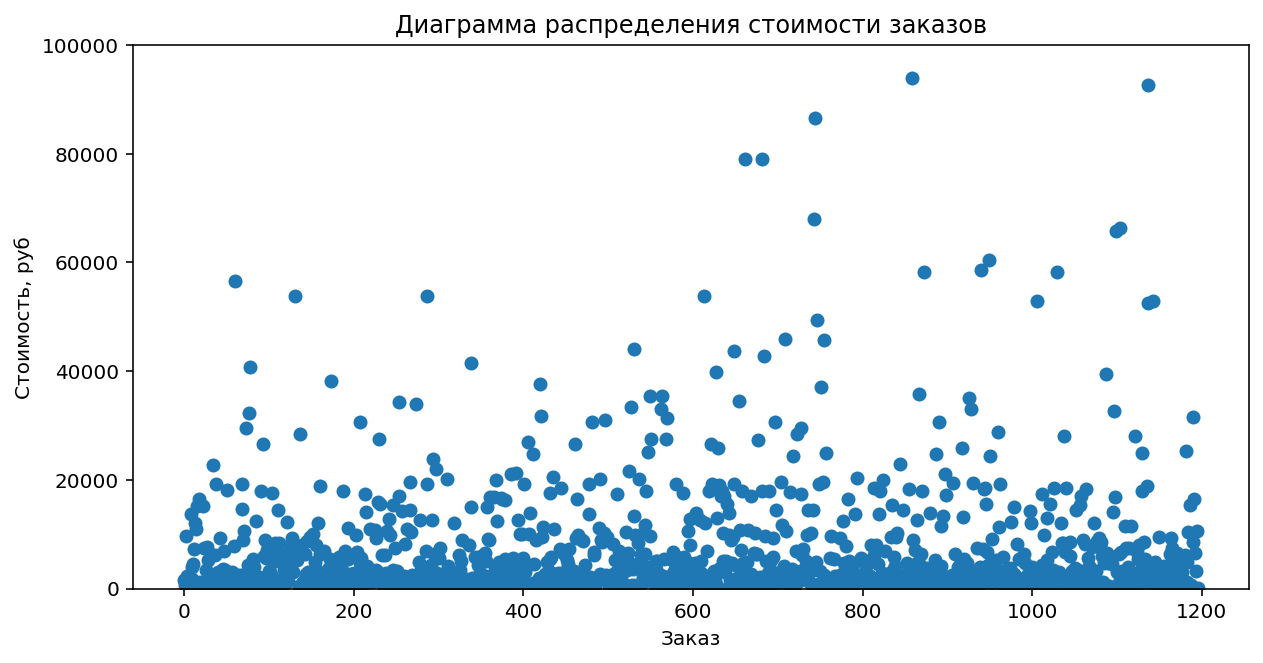

In [33]:
# Построим точечную диаграмму и изменим масштаб по оси оу:
plt.figure(figsize=(10, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 0.1*1e6)
plt.xlabel('Заказ')
plt.ylabel('Стоимость, руб')
plt.title('Диаграмма распределения стоимости заказов'); 

Стоимость большей части заказов менее 20 000 руб, однако не малая часть заказов находится в диапазоне от 20 000 до 40 000 руб. Чтобы точнее определить границу аномальных заказов, посчитаем перцентили.

### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [34]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5 % заказов дороже 28 000 рублей и не более 1 % дороже 58 233 рублей. 

За границу аномальной стоимости заказов примем значение в 28 000 руб.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на посетителя и среднем чеке между группами *без удаления аномальных пользователей*.

Сформулируем гипотезы:
- Нулевая: различий в среднем количестве заказов на посетителя между группами нет;
- Альтернативная: различия в среднем количестве заказов на посетителя между группами есть.

Подготовим данные.

In [35]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [36]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [37]:
# Создадим переменные ordersByUsersA и ordersByUsersB. В них для пользователей, которые заказывали 
# хотя бы 1 раз, укажем число совершённых заказов:

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.
Таким образом, мы подготавливаем выборку к проверке **критерием Манна-Уитни**. Данный критерий выбираем для анализа, потому что он применим даже в том случае, если распределение ненормальное и в данных есть выбросы.

За критический уровень статистической значимости примем значение 0.05.

In [38]:
sampleA = (pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].
                                     sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0))

sampleB = (pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].
                                    sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)) 

In [39]:
# Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Выведем относительный прирост среднего числа заказов на посетителя группы B: 
print("Прирост среднего числа заказов на посетителя группы В: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
Прирост среднего числа заказов на посетителя группы В: 0.138


Отвергаем нулевую гипотезу: по «сырым» данным различие в среднем количестве заказов на посетителя между группами есть.

Прирост среднего числа заказов на посетителя группы B - 13,8 %.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:
- Нулевая: различий в среднем чеке заказа между группами нет;
- Альтернативная: различия в среднем чеке заказа между группами есть.

Критический уровень статистической значимости остается тем же 0.05.

In [40]:
# Найдём относительные различия в среднем чеке между группами:
(
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                   orders[orders['group']=='B']['revenue'])[1]))
)
(
print('Прирост среднего чека заказа группы В: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                                                                orders[orders['group']=='A']['revenue'].mean()-1))
)    

p-value: 0.729
Прирост среднего чека заказа группы В: 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. В то же время, средний чек группы B выше среднего чека группы A на 25,9 %.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [41]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsersA['orders'], 95)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsersA['orders'], 95)]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print('Аномальные пользователи:', abnormalUsers.shape[0])
print('Процент аномальных пользователей:', round(abnormalUsers.shape[0]*100 / orders['visitor_id'].nunique(), 1))

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
Аномальные пользователи: 74
Процент аномальных пользователей: 7.2


Всего получилось 74 аномальных пользователя, 7.2  % от общего числа пользователей, принявших участие в А/В тесте.

Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. 

In [42]:
### Подготовим выборки количества заказов по пользователям по группам теста:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [43]:
# Применим статистический критерий Манна-Уитни к полученным выборкам:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Прирост среднего числа заказов на посетителя группы В: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.013
Прирост среднего числа заказов на посетителя группы В: 0.173


Результаты по среднему количеству заказов на посетителя практически не изменились. 
Как оказалось, аномальные пользователи не повлияли на результаты теста.
Как и в случае с «сырыми» данными, мы отвергаем нулевую гипотезу: по «очищенным» данным различие в среднем количестве заказов на посетителя между группами есть.

Прирост среднего числа заказов на посетителя группы B по «очищенным» данным несколько выше, чем по «сырым» - 17,3 %.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [44]:
# Найдём относительные различия в среднем чеке между группами по «очищенным» данным:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Прирост среднего чека заказа группы В: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value: 0.738
Прирост среднего чека заказа группы В: -0.020


P-value по «очищенным» данным также значительно больше 0.05. Нулевую гипотезу, что в среднем чеке есть различия, отвергаем. В результате анализа очищенных данных оказалось, что средний чек группы B ниже среднего чека группы A на 2,0 %.

Выводы по разделу 3:

- На основании графика кумулятивной выручки по группам можно сделать вывод, что в группе В выручка больше, чем в группе А;
- На графике кумулятивного среднего чека по группам видно, что средний чек в группе В, больше чем группе А. Однако, на этом графике, а также на графике относительного изменения кумулятивного среднего чека группы B к группе A, где также наблюдается явное преимущество группы В, видны резкие всплески, что говорит нам о сильном влиянии аномалий - очень крупных заказах и выбросах; 
- На графиках кумулятивного среднего количества заказов на посетителя по группам и относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A также можно зафиксировать значительное преимущество группы В над А, однако и здесь не стоит исключать наличия аномалий;
- С помощью точечных графиков и расчетов перцентилей определены: граница аномальных заказов – 2 заказа и граница аномальной стоимости заказов – 28 000 руб;
- Статистически значимое различие по среднему количеству заказов на посетителя между группами как по «сырым», так и по данным после фильтрации аномалий есть. Прирост среднего числа заказов группы B по «сырым» данным - 13,8 %, по «очищенным» данным – 17,3 %;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. В то же время средний чек группы B по «сырым» данным выше среднего чека группы A на 25,9 %, а по «очищенным» - ниже на 2 %. 


## Общий вывод

- Исходные данные проверены на наличие пропусков и явных дубликатов, заголовки столбцов приведены к нижнему и «змеиному» регистрам, тип данных в столбцах с датой переведен в формат datetime, проведена приоритизация гипотез, определено, сколько групп в А/В тесте, сколько пользователей попало в обе группы одновременно и принято решение не удалять таких пользователей,т.к. их процент мал, выполнена приоритизация гипотез методами ICE и RICE, проведен А/В тест: определены границы аномальных пользователей и стоимости заказов, посчитана статистическая значимость различий в среднем количестве заказов на посетителя между группами и статистическая значимость различий в среднем чеке заказа между группами как по «сырым», так и «очищенным» данным.

- Самая перспективная гипотеза, которую можно порекомендовать после приоритизации всех гипотез по фреймворку ICE: *Запустить акцию, дающую скидку на товар в день рождения*. А самая перспективная гипотеза,  которую можно порекомендовать после приоритизации всех гипотез по фреймворку RICE, т.е. с учетом того, скольких пользователей затронет изменение: *Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*.

- Статистически значимого различия по среднему чеку между группами как по «сырым» данным, так и после удаления аномалий нет. 

- Как по «сырым» так и по «очищенным» есть статистически значимое различие по среднему количеству заказов на посетителя между группами. Среднее число заказов на посетителя группы B больше, чем в группы А на 17,3 % (по «сырым» данным на 13,8 %).

- График различия среднего количества заказов на посетителя между группами также подтверждает, что результаты группы B лучше группы A на протяжении всего теста: имеют тенденцию к росту, либо зафиксировались около среднего значения.

- Таким образом, можно принять решение об остановке теста и зафиксировать победу группы В.

- В дальнейшем рекомендуется более тщательно подходить к разделению пользователей на группы, чтобы один и тот же пользователь не попадал в обе группы одновременно,а также стараться набирать близкие по числу пользователей группы. 